# Trabalho TP3 Ex2
## Grupo 27
### LCC 2024/2025
#### Gonçalo Gonçalves Barroso A102931
#### Rafaela Antunes Pereira A102527
#### Ricardo Eusebio Cerqueira A102878

In [1]:
%pip install pysmt
%pip install z3-solver


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



Problema 2

Relativo ao programa do problema anterior,

a) Construa um “Control Flow Automaton (CFA)” que determina este programa. Identifique os locais e as transições/ramos.  Numa abordagem orientada às pré-condições  identifique os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos.


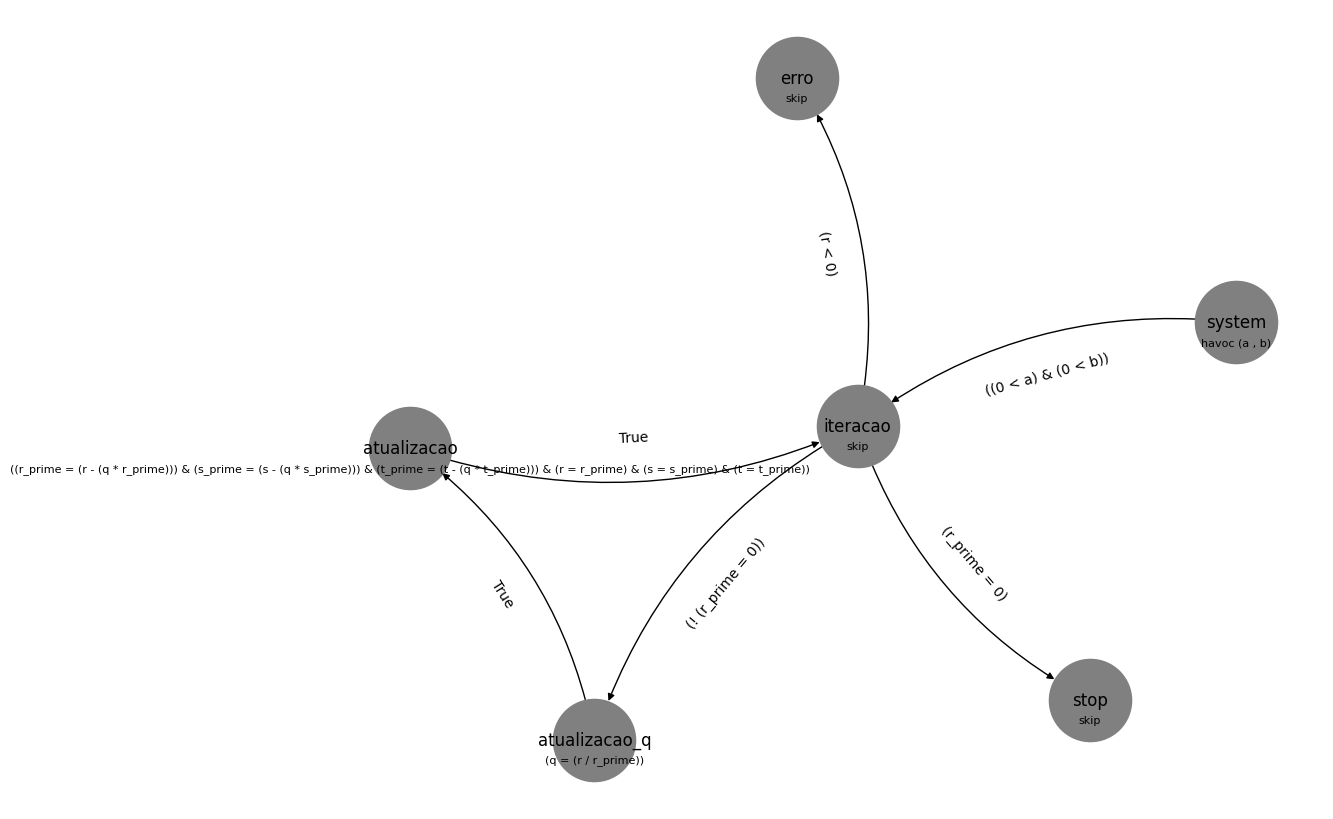

In [2]:
from pysmt.shortcuts import *
from pysmt.typing import INT
import networkx as nx
import matplotlib.pyplot as plt

# Criar o grafo do CFA
G = nx.DiGraph()

# Definindo os símbolos
a = Symbol("a", INT)
b = Symbol("b", INT)
r = Symbol("r", INT)
r_prime = Symbol("r_prime", INT)
s = Symbol("s", INT)
s_prime = Symbol("s_prime", INT)
t = Symbol("t", INT)
t_prime = Symbol("t_prime", INT)
q = Symbol("q", INT)

# Nodos
nodos =[
    ("system", "havoc (a , b)"),
    ("iteracao", "skip"),
    ("erro", "skip"),
    ("atualizacao", And(Equals(r_prime, Minus(r, Times(q, r_prime))), 
                        Equals(s_prime, Minus(s, Times(q, s_prime))),
                        Equals(t_prime, Minus(t, Times(q, t_prime))),
                        Equals(r, r_prime),
                        Equals(s, s_prime),
                        Equals(t, t_prime))),
    ("atualizacao_q", Equals(q, Div(r, r_prime))),
    ("stop", "skip"),
]

# Transições
edges = [
    ("system", "iteracao", And(GT(a, Int(0)), GT(b, Int(0)))),
    ("iteracao", "erro", LT(r, Int(0))),  # Erro quando r < 0 (overflow)
    ("atualizacao", "iteracao", TRUE()),
    ("iteracao", "stop", Equals(r_prime, Int(0))),  # Condição de parada correta
    ("atualizacao_q", "atualizacao", TRUE()),
    ("iteracao", "atualizacao_q", NotEquals(r_prime, Int(0))),
]


for node, annotation in nodos:
    G.add_node(node, annotation = annotation)
for source, target, condition in edges:
    G.add_edge(source, target, condition = condition)


# Desenhando o grafo sem labels externos
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels = True, node_size = 3500, connectionstyle="arc3,rad=0.2", node_color = 'grey')

edge_conds = nx.get_edge_attributes(G, name = "condition")
nx.draw_networkx_edge_labels(G, pos, edge_conds)

annotations = nx.get_node_attributes(G, 'annotation')
for node, annotation in annotations.items():
    xp, yp = pos[node]
    plt.text(xp, yp- 0.04, annotation, fontsize=8, ha='center', va='top')

plt.show()


b) Construa em z3 o sistema de equações que representa o comportamento deste sistema dinâmico sob o ponto de vista da prova de segurança e verifique a segurança do programa através da resolução (total ou parcial) deste sistema.

Usando a função *graph_safety* disponibilizda na ficha 5, com algumas alterações, conseguimos verificar a segurança do programa.

In [3]:
def graph_safety(G, n):
    print(f"> A testar {n} iterações.")
    
    with Solver(name = "z3") as solver:
    
      # Definindo os símbolos
      r = Symbol("r", INT)
      r_prime = Symbol("r_prime", INT)
      s = Symbol("s", INT)
      s_prime = Symbol("s_prime", INT)
      t = Symbol("t", INT)
      t_prime = Symbol("t_prime", INT)
      q = Symbol("q", INT)

      error = TRUE()
      stop = FALSE()

      do = FALSE()


      for source, target, data in G.edges(data = True):
          if source == "system" and target == "iteracao":
              guarda = data["condition"]


      for i in range(n):
          system = And(guarda, do)
          if solver.solve([system]):
            print(f"> Iteração {i}: sistema inseguro.")
            return

          clauses = []
          for source, target, data in G.edges(data = True):
              if source == "iteracao":
                condition = data["condition"]
                if target == "erro":
                  clauses.append(Implies(condition, error))
                elif target == "stop":
                  clauses.append(Implies(condition, stop))
                elif target == "atualizacao_q":
                  sub = {q :Div(r, r_prime)}
                  atrib = substitute(do, sub)
                  clauses.append(Implies(condition, atrib))
                elif target == "atualizacao":
                  sub = {
                    r : r_prime,
                    s : s_prime,
                    t : t_prime,
                    r_prime : r - q * r_prime,
                    s_prime : s - q * s_prime,
                    t_prime : t - q * t_prime
                  }
                  atrib = substitute(do, sub)
                  clauses.append(Implies(condition, atrib))

          new_do = And(clauses)

          # Tentar generalizar.
          R = And(do, Not(new_do))
          L =  And(new_do, Not(do))
          if solver.is_unsat(Or(R, L)):
              # do_n <-> do_{n-1}
              print(f"> Iteração {i}: sistema seguro.")
              return

          do = Or(do, new_do)

      print("> Não foram encontrados estados inseguros.")

graph_safety(G, 10)

> A testar 10 iterações.
> Iteração 0: sistema seguro.
